In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [122]:
!wget https://habrastorage.org/r/w1560/storage2/d7e/95c/c9a/d7e95cc9a4a5f1f571ef1f3b3521ede4.jpg -O seam_carving.png

--2024-11-17 10:12:42--  https://habrastorage.org/r/w1560/storage2/d7e/95c/c9a/d7e95cc9a4a5f1f571ef1f3b3521ede4.jpg
Resolving habrastorage.org (habrastorage.org)... 45.120.177.159, 2a01:4f9:3b:48e8::4115:7879, 2a01:4f9:4a:2897::5fd9:6b0c
Connecting to habrastorage.org (habrastorage.org)|45.120.177.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48253 (47K) [image/jpeg]
Saving to: ‘seam_carving.png’

seam_carving.png    100%[===================>]  47,12K  --.-KB/s    in 0,1s    

2024-11-17 10:12:44 (368 KB/s) - ‘seam_carving.png’ saved [48253/48253]



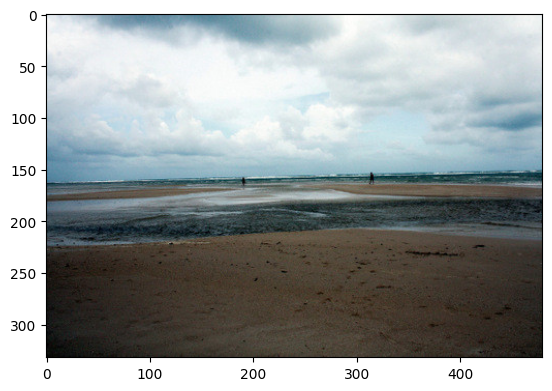

In [180]:
img = cv2.imread("seam_carving.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img) 

In [237]:
!rm -f seam_carving.png

In [233]:
def calculate_energy(img: np.array):
    """
    img: np.array (H x W x C)
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
    gradient_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    
    grad = np.abs(gradient_x) + np.abs(gradient_y)
    return grad.astype(np.float32)

def calculate_energy_seam(energies, axis=0):
    """Calculates energy seam

    Args:
        energies (np.array): (H x W) enery of image
        axis (int, optional): width or height. Defaults to 0.

    Returns:
        np.array: energy seam
    """
    energy_seam = energies.copy()
    for i in range(1, energies.shape[0]):
        for j in range(0, energies.shape[1]):
            left = energy_seam[i - 1, j - 1] if j > 0 else float('inf')
            mid = energy_seam[i - 1, j]
            right = energy_seam[i - 1, j + 1] if j < energies.shape[1] - 1 else float('inf')
            energy_seam[i, j] += min(left, mid, right)

    return energy_seam


def calculate_min_seam_indices(acc_seam):
    """calculate indices of minimal seam

    Args:
        acc_seam (np.array): (H x W) accumulated energy

    Returns:
        list: list of indices
    """
    index_list = [(acc_seam.shape[0] - 1, np.argmin(acc_seam[-1]))]
    for i in range(acc_seam.shape[0] - 2, -1, -1): # vertical seam
        prev_index = index_list[-1][1]
        idx = prev_index
        if prev_index > 0 and acc_seam[i, prev_index - 1] < acc_seam[i, idx]:
            idx = prev_index - 1
        if prev_index < acc_seam.shape[1] - 1 and acc_seam[i, prev_index + 1] < acc_seam[i, idx]:
            idx = prev_index + 1

        index_list.append((i, idx))

    return index_list

def seam_carving(img, n_seams):
    """performs seam carving

    Args:
        img (np.array): (H x W x C)
        n_seams (int): number of seams

    Returns:
        np.array: carved image
    """
    img = img.copy()
    visualization_mask = np.zeros_like(img, dtype=np.bool)
    for i in range(n_seams):
        energies = calculate_energy(img)
        seam_energies = calculate_energy_seam(energies)
        min_seam_indices = calculate_min_seam_indices(seam_energies)

        mask = np.ones_like(img, dtype=np.bool)
        for row, col in min_seam_indices:
            mask[row, col, :] = 0
            visualization_mask[row, col, :] = 1 # Not correct masking cuz should take into account previous seams, but okay 
        img = img[mask].reshape(img.shape[0], img.shape[1] - 1, -1)
    return img, visualization_mask

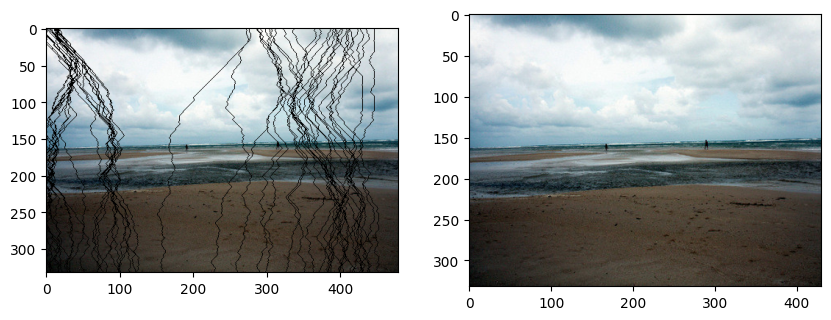

In [236]:
resized_img, mask = seam_carving(img, 50)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.where(mask, (0, 0, 0), img))
plt.subplot(1, 2, 2)
plt.imshow(resized_img)

(<matplotlib.image.AxesImage at 0x133645f40>, (332, 480))

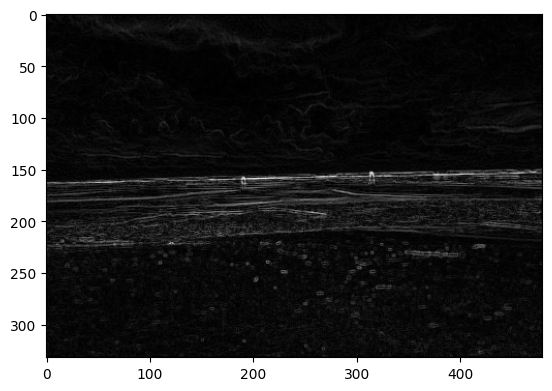

In [198]:
energy = calculate_energy(img)
plt.imshow(energy, cmap='gray'), energy.shape